Config settings:
N: 10
T_train_val: 10000
T_test: 1000
data_type: ar1
batch_size: 64
seq_length: 20
input_size: 10
output_size: 10
learning_rate: 0.001
num_epochs: 100
num_workers: 24
device: cuda
mix_precision: True
dg_config:
    mean_load: 50.0
    var_load: 10.0
    iid_var: 1.0
    theta: 0.9
ar_config:
    order: 5
lstm_config:
    hidden_size: 50
    num_layers: 4
gat_config:
    num_heads: 8
    num_layers: 3
--------------------------------------------------
load_iid.shape: (10, 11000)
load_iid.type: <class 'numpy.ndarray'>
load_ar1.shape: (10, 11000)
load_ar1.type: <class 'numpy.ndarray'>
data.shape: (10, 11000)
data.type: <class 'numpy.ndarray'>
train_val_data.shape: (10, 10000)
train_val_data.type: <class 'numpy.ndarray'>
test_data.shape: (10, 1000)
test_data.type: <class 'numpy.ndarray'>
train_sets.shape: torch.Size([9980, 20, 10])
train_sets.type: <class 'torch.Tensor'>
val_sets.shape: torch.Size([9980, 10])
val_sets.type: <class 'torch.Tensor'>
len(train_val_dataset): 99

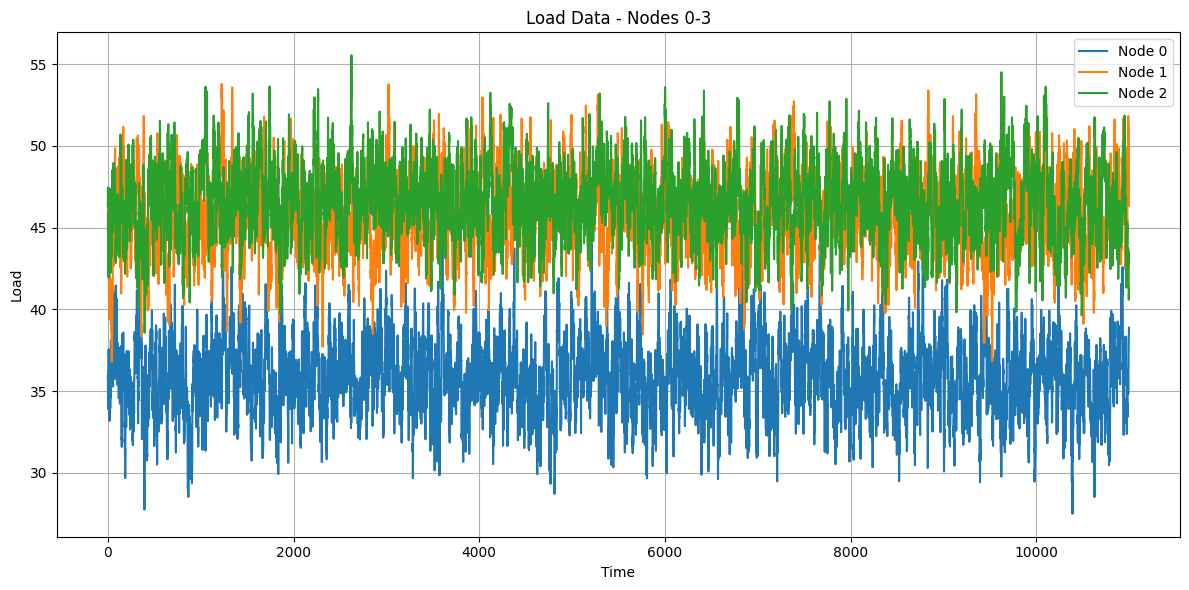

In [1]:
from Config_Data import Config, DataGenerateConfig, ARConfig, LSTMConfig, GATConfig, DataGenerate, DataManage
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'

config = Config(
    N=10,
    T_train_val=10000,
    T_test=1000,
    data_type='ar1',

    batch_size=64,
    seq_length=20,
    input_size=10,
    output_size=10,
    learning_rate=0.001,
    num_epochs=100,
    num_workers=24,
    device= device,
    mix_precision=True if device == 'cuda' else False,

    patience_epochs=6,
    min_delta=1e-2,

    mode='min',
    factor=0.1,
    patience_lr=2,
    min_lr=1e-6,
    threshold=1e-2,

    dg_config=DataGenerateConfig(mean_load=50.0, var_load=10.0, iid_var=1.0, theta=0.9),
    ar_config=ARConfig(order=5),
    lstm_config=LSTMConfig(hidden_size=50, num_layers=4),
    gat_config=GATConfig(num_heads=8, num_layers=3),
)
config.print_config_info()

RE_GENERATE_DATA = False

if RE_GENERATE_DATA:
    data_generate = DataGenerate(config)

data_manage = DataManage(config)
data = data_manage.data

data_manage.plot_range_data(data[:3, :], start=0, end=len(data[0]), title='Load Data')

In [2]:
data_manage.print_data_manage_info()

load_iid.shape: (10, 11000)
load_iid.type: <class 'numpy.ndarray'>
load_ar1.shape: (10, 11000)
load_ar1.type: <class 'numpy.ndarray'>
data.shape: (10, 11000)
data.type: <class 'numpy.ndarray'>
train_val_data.shape: torch.Size([10, 10000])
train_val_data.type: <class 'torch.Tensor'>
test_data.shape: torch.Size([10, 1000])
test_data.type: <class 'torch.Tensor'>
train_sets.shape: torch.Size([9980, 20, 10])
train_sets.type: <class 'torch.Tensor'>
val_sets.shape: torch.Size([9980, 10])
val_sets.type: <class 'torch.Tensor'>
len(train_val_dataset): 9980
len(dataloader): 156


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
class LSTMExpert:
    def __init__(self, config, data_manage):
        self.config = config
        self.data_manage = data_manage

        # 创建模型
        self.model = self.LSTMModel(self.config.input_size, self.config.lstm_config.hidden_size,
                                    self.config.output_size, self.config.lstm_config.num_layers).to(self.config.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)

        self.predictions = None
        self.true_values = None

        self.total_avg_loss = 0

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, num_layers):
            super().__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.layer_norm = nn.LayerNorm(hidden_size)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h_0, c_0))
            out = self.layer_norm(out[:, -1, :])
            out = self.fc(out)
            return out

    def train(self):
        scaler = torch.amp.GradScaler(device=self.config.device) if self.config.mix_precision else None

        self.model.train()
        for epoch in tqdm(range(self.config.num_epochs), desc="Training"):
            for train, val in self.data_manage.dataloader:
                # 确保数据在 GPU 上，且异步加载
                train, val = train.to(self.config.device, non_blocking=True).float(), val.to(self.config.device, non_blocking=True).float()

                self.optimizer.zero_grad()  # 梯度清零

                if self.config.mix_precision:  # 混合精度训练
                    with torch.amp.autocast(device_type=self.config.device):
                        pred = self.model(train)
                        loss = self.criterion(pred, val)

                    scaler.scale(loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()

                else:
                    pred = self.model(train)  # 前向传播
                    loss = self.criterion(pred, val)  # 计算损失
                    loss.backward()  # 反向传播
                    self.optimizer.step()  # 更新参数

            if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
                print(f'Epoch [{epoch + 1}/{self.config.num_epochs}], Loss: {loss.item():.4f}')

                if torch.cuda.is_available():  # 释放GPU缓存
                    torch.cuda.empty_cache()

                print(f'device: {torch.cuda.get_device_name()}')

    def predict_and_fine_tune(self):
        total_loss = 0
        predictions = torch.zeros((self.config.T_test, self.config.output_size), device=self.config.device)
        true_values = torch.zeros((self.config.T_test, self.config.output_size), device=self.config.device)

        # 选择训练集的最后一部分数据作为输入
        input_data = self.data_manage.train_val_data[:, -self.config.seq_length:].T.unsqueeze(0).to(self.config.device)  #  shape: [1, seq_length, input_size], [1, 20, 10]
        
        #  测试数据集
        test_data = self.data_manage.test_data.to(self.config.device)  # 将测试数据转移到 GPU, shape: [T_test, output_size], [1000, 10]

        for i in tqdm(range(self.config.T_test), desc="Predicting and Fine-tuning"):
            self.model.train()  # 模型保持在训练模式，以便进行微调
            pred = self.model(input_data)  # 预测 shape: [1, output_size], [1, 10]
            real_value = test_data[:, i].to(self.config.device)  # 真实值, shape: [output_size], [10]

            # predictions.append(pred.squeeze(0).detach().cpu().numpy())
            # # 形状[1, 10]转换为 [10], 从计算图中分离(以分离开梯度，不然没法使用.numpy())，从GPU转移到CPU, 最后转为 NumPy 数组
            # true_values.append(real_value.detach().cpu().numpy())

            predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]
            true_values[i] = real_value  # 将真实值保存到 true_values, shape: [T_test, output_size], [1000, 10]

            loss = self.criterion(pred.squeeze(0), real_value)  # 计算损失
            total_loss += loss.item()  # 累加损失
            if (i + 1) % 100 == 0:  # 每100步输出一次损失
                print(f'Step {i + 1}/{self.config.T_test}, Loss: {loss.item():.4f}')

            # 使用真实值进行微调
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # 更新输入序列
            input_data = torch.cat((input_data[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)

        # 计算平均损失
        avg_loss = total_loss / self.config.T_test
        print(f'Average Fine-tuning Loss over {self.config.T_test} steps: {avg_loss:.4f}')

        self.total_avg_loss = avg_loss

        # 将预测值和真实值转换为 NumPy 数组
        # self.predictions = np.array(predictions)
        # self.true_values = np.array(true_values)
        self.predictions = predictions.detach().cpu().numpy()
        self.true_values = true_values.detach().cpu().numpy()

    def get_prediction_at_time(self, t):
        if self.predictions is None or self.true_values is None:
            raise ValueError("You must run predict_and_fine_tune() before accessing predictions.")
        return self.predictions[t], self.true_values[t]

    def get_total_avg_loss(self):
        return self.total_avg_loss

    def plot_results(self, predictions, true_values):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions[:, 0], label='Predicted')
        plt.plot(true_values[:, 0], label='True')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Value')
        plt.title('Predicted vs True Load Values for Node 1')
        plt.legend()
        plt.show()

In [6]:
expert = LSTMExpert(config, data_manage)

In [7]:
%%time
expert.train()

Training:  10%|█         | 10/100 [02:14<16:35, 11.06s/it]

Epoch [10/100], Loss: 5.3011
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  20%|██        | 20/100 [03:55<13:10,  9.88s/it]

Epoch [20/100], Loss: 3.9332
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  30%|███       | 30/100 [05:38<12:07, 10.40s/it]

Epoch [30/100], Loss: 3.1408
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  40%|████      | 40/100 [07:21<10:03, 10.06s/it]

Epoch [40/100], Loss: 2.0979
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  50%|█████     | 50/100 [09:04<08:22, 10.04s/it]

Epoch [50/100], Loss: 1.2213
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  60%|██████    | 60/100 [10:48<07:10, 10.77s/it]

Epoch [60/100], Loss: 1.3721
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  70%|███████   | 70/100 [12:26<04:55,  9.85s/it]

Epoch [70/100], Loss: 1.2377
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  80%|████████  | 80/100 [14:09<03:27, 10.37s/it]

Epoch [80/100], Loss: 1.1119
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  90%|█████████ | 90/100 [15:51<01:41, 10.11s/it]

Epoch [90/100], Loss: 1.0239
device: NVIDIA GeForce RTX 4060 Laptop GPU


Training: 100%|██████████| 100/100 [17:33<00:00, 10.54s/it]

Epoch [100/100], Loss: 0.9497
device: NVIDIA GeForce RTX 4060 Laptop GPU
CPU times: total: 24.4 s
Wall time: 17min 33s



'cuda': GeForce GTX 4060 Laptop GPU
CPU times: total: 20.1 s
Wall time: 17min 44s

In [8]:
%%time
expert.predict_and_fine_tune()  # 预测并微调

Predicting and Fine-tuning:  16%|█▌        | 160/1000 [00:00<00:02, 340.84it/s]

Step 100/1000, Loss: 5.2405


Predicting and Fine-tuning:  26%|██▋       | 265/1000 [00:00<00:02, 338.34it/s]

Step 200/1000, Loss: 4.3135


Predicting and Fine-tuning:  34%|███▎      | 337/1000 [00:01<00:01, 345.71it/s]

Step 300/1000, Loss: 6.6539


Predicting and Fine-tuning:  45%|████▍     | 446/1000 [00:01<00:01, 314.70it/s]

Step 400/1000, Loss: 7.0991


Predicting and Fine-tuning:  55%|█████▌    | 554/1000 [00:01<00:01, 336.78it/s]

Step 500/1000, Loss: 4.5899


Predicting and Fine-tuning:  66%|██████▌   | 658/1000 [00:02<00:01, 324.34it/s]

Step 600/1000, Loss: 3.9827


Predicting and Fine-tuning:  76%|███████▋  | 764/1000 [00:02<00:00, 342.42it/s]

Step 700/1000, Loss: 3.7968


Predicting and Fine-tuning:  88%|████████▊ | 879/1000 [00:02<00:00, 367.69it/s]

Step 800/1000, Loss: 8.0426


Predicting and Fine-tuning:  96%|█████████▌| 956/1000 [00:02<00:00, 368.02it/s]

Step 900/1000, Loss: 3.0957


Predicting and Fine-tuning: 100%|██████████| 1000/1000 [00:02<00:00, 339.32it/s]

Step 1000/1000, Loss: 5.2778
Average Fine-tuning Loss over 1000 steps: 5.2277
CPU times: total: 859 ms
Wall time: 2.95 s


'cuda': GeForce GTX 4060 Laptop GPU
CPU times: total: 906 ms
Wall time: 3 s

In [9]:
t = 50
predicted, true_value = expert.get_prediction_at_time(t)
print(f"Predicted values for t={t}: {predicted}")
print(f"True values for t={t}: {true_value}")

Predicted values for t=50: [37.06549  48.543945 41.20741  40.5606   48.207382 55.655567 69.88576
 52.924034 50.948895 48.187622]
True values for t=50: [37.979206 46.101223 46.028137 41.439808 47.125584 51.89477  71.41243
 51.108482 51.90689  50.92283 ]


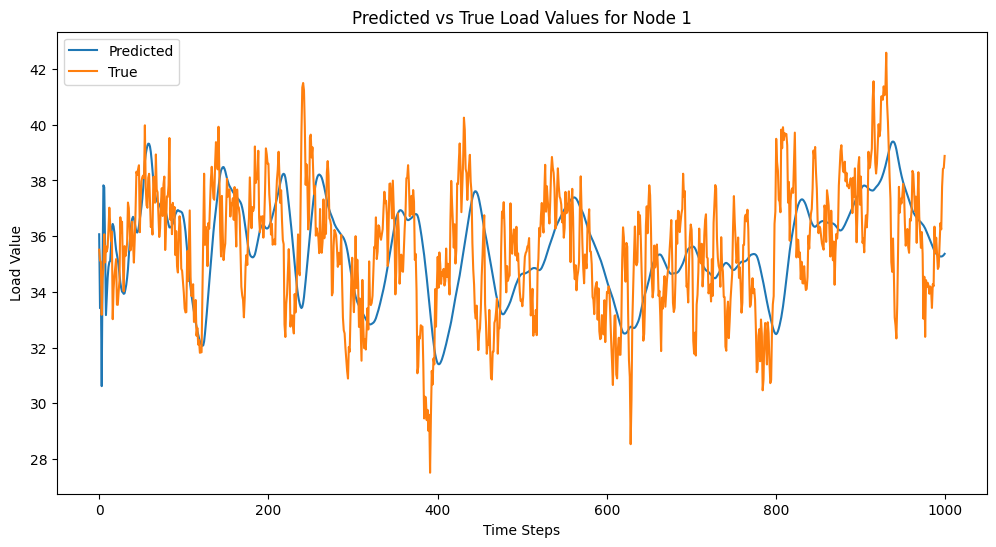

In [10]:
# 绘制预测与真实值对比图
expert.plot_results(expert.predictions, expert.true_values)
